In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy dataset creation
np.random.seed(42)
X = np.random.randn(15, 4) * 10 + 50
y_reg = X[:, 0] + 2 * X[:, 1] - X[:, 2] + np.random.randn(15) * 5
y_clf = (y_reg > np.median(y_reg)).astype(int)

# Train-test split (80/20)
train_idx = np.arange(12)
test_idx = np.arange(12, 15)

X_train, X_test = X[train_idx], X[test_idx]
y_reg_train, y_reg_test = y_reg[train_idx], y_reg[test_idx]
y_clf_train, y_clf_test = y_clf[train_idx], y_clf[test_idx]

Linear Regression MSE: 156.2890


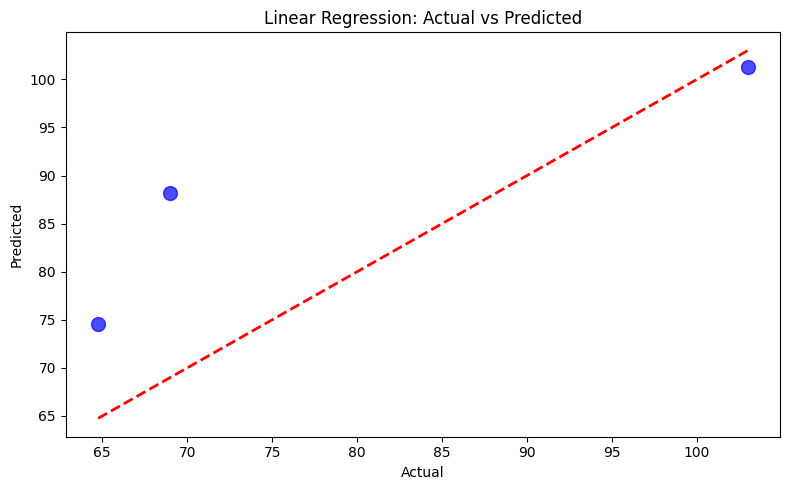

In [5]:
# 1. Linear Regression
class LinearRegression:
    def __init__(self, lr=0.01, epochs=100):
        self.lr, self.epochs = lr, epochs
        self.w = None
        self.b = 0
    
    def fit(self, X, y):
        if self.w is None:
            self.w = np.zeros(X.shape[1])
        m = X.shape[0]
        for _ in range(self.epochs):
            pred = X @ self.w + self.b
            dw = (2/m) * (X.T @ (pred - y))
            db = (2/m) * np.sum(pred - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db
        return self
    
    def predict(self, X):
        return X @ self.w + self.b

lr_model = LinearRegression(lr=0.0001, epochs=100).fit(X_train, y_reg_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = np.mean((y_pred_lr - y_reg_test)**2)
print(f"Linear Regression MSE: {mse_lr:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_reg_test, y_pred_lr, color='blue', alpha=0.7, s=100)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs Predicted')
plt.tight_layout()
plt.show()

Logistic Regression Accuracy: 1.0000


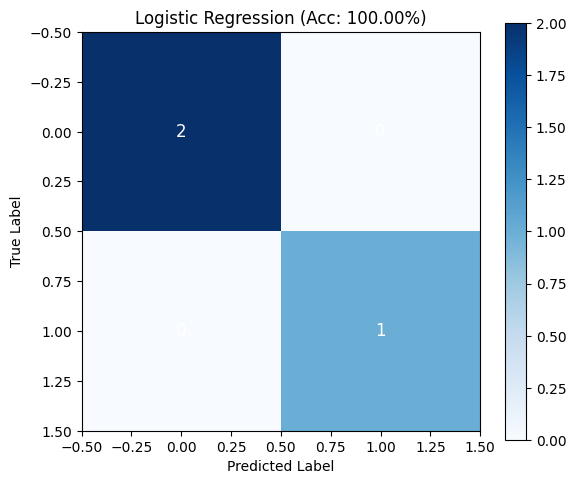

In [6]:
# 2. Logistic Regression
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=100):
        self.lr, self.epochs = lr, epochs
        self.w = None
        self.b = 0
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def fit(self, X, y):
        if self.w is None:
            self.w = np.zeros(X.shape[1])
        m = X.shape[0]
        for _ in range(self.epochs):
            pred = self.sigmoid(X @ self.w + self.b)
            dw = (1/m) * (X.T @ (pred - y))
            db = (1/m) * np.sum(pred - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db
        return self
    
    def predict(self, X):
        return (self.sigmoid(X @ self.w + self.b) > 0.5).astype(int)

log_model = LogisticRegression(lr=0.01, epochs=100).fit(X_train, y_clf_train)
y_pred_log = log_model.predict(X_test)
acc_log = np.mean(y_pred_log == y_clf_test)
print(f"Logistic Regression Accuracy: {acc_log:.4f}")

# Confusion Matrix
tp = np.sum((y_pred_log == 1) & (y_clf_test == 1))
tn = np.sum((y_pred_log == 0) & (y_clf_test == 0))
fp = np.sum((y_pred_log == 1) & (y_clf_test == 0))
fn = np.sum((y_pred_log == 0) & (y_clf_test == 1))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title(f'Logistic Regression (Acc: {acc_log:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

KNN Accuracy: 0.6667


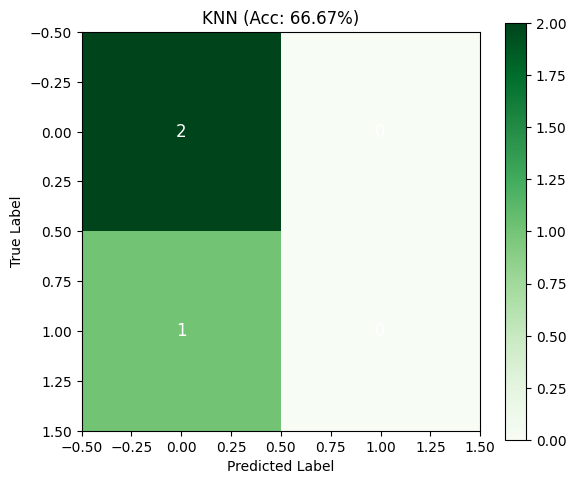

In [7]:
# 3. K-Nearest Neighbors
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train, self.y_train = None, None
    
    def fit(self, X, y):
        self.X_train, self.y_train = X, y
        return self
    
    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_idx = np.argsort(distances)[:self.k]
            k_neighbors = self.y_train[k_idx]
            predictions.append(np.bincount(k_neighbors).argmax())
        return np.array(predictions)

knn_model = KNN(k=3).fit(X_train, y_clf_train)
y_pred_knn = knn_model.predict(X_test)
acc_knn = np.mean(y_pred_knn == y_clf_test)
print(f"KNN Accuracy: {acc_knn:.4f}")

tp = np.sum((y_pred_knn == 1) & (y_clf_test == 1))
tn = np.sum((y_pred_knn == 0) & (y_clf_test == 0))
fp = np.sum((y_pred_knn == 1) & (y_clf_test == 0))
fn = np.sum((y_pred_knn == 0) & (y_clf_test == 1))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Greens', interpolation='nearest')
plt.title(f'KNN (Acc: {acc_knn:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

Decision Tree Accuracy: 0.6667


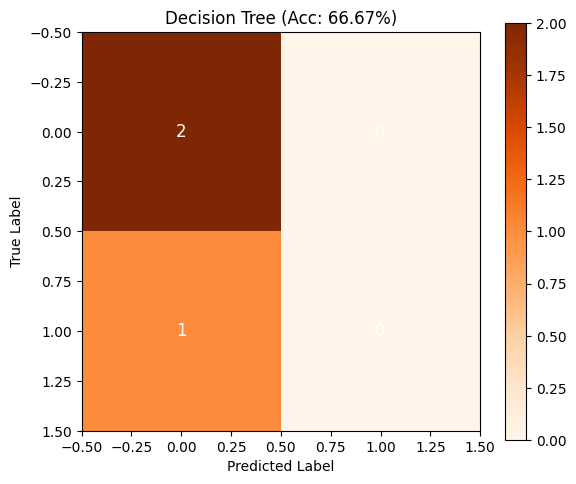

In [16]:
# 4. Decision Tree (Classification)
class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None
    
    def entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return -np.sum(probs * np.log2(probs + 1e-10))
    
    def split(self, X, y, feature, threshold):
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx
        return left_idx, right_idx
    
    def best_split(self, X, y):
        best_gain, best_feat, best_thresh = 0, None, None
        parent_entropy = self.entropy(y)
        for feat in range(X.shape[1]):
            thresholds = np.unique(X[:, feat])
            for thresh in thresholds:
                left_idx, right_idx = self.split(X, y, feat, thresh)
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gain = parent_entropy - (len(y[left_idx])/len(y) * self.entropy(y[left_idx]) + 
                                        len(y[right_idx])/len(y) * self.entropy(y[right_idx]))
                if gain > best_gain:
                    best_gain, best_feat, best_thresh = gain, feat, thresh
        return best_feat, best_thresh
    
    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1 or depth == self.max_depth:
            return int(np.bincount(y).argmax())
        feat, thresh = self.best_split(X, y)
        if feat is None:
            return int(np.bincount(y).argmax())
        left_idx, right_idx = self.split(X, y, feat, thresh)
        return {'feat': feat, 'thresh': thresh, 'left': self.build_tree(X[left_idx], y[left_idx], depth+1),
                'right': self.build_tree(X[right_idx], y[right_idx], depth+1)}
    
    def fit(self, X, y):
        self.tree = self.build_tree(X, y)
        return self
    
    def predict_sample(self, x, tree):
        if isinstance(tree, (int, np.integer)):
            return tree
        return self.predict_sample(x, tree['left'] if x[tree['feat']] <= tree['thresh'] else tree['right'])
    
    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])

dt_model = DecisionTree(max_depth=5).fit(X_train, y_clf_train)
y_pred_dt = dt_model.predict(X_test)
acc_dt = np.mean(y_pred_dt == y_clf_test)
print(f"Decision Tree Accuracy: {acc_dt:.4f}")

tp = np.sum((y_pred_dt == 1) & (y_clf_test == 1))
tn = np.sum((y_pred_dt == 0) & (y_clf_test == 0))
fp = np.sum((y_pred_dt == 1) & (y_clf_test == 0))
fn = np.sum((y_pred_dt == 0) & (y_clf_test == 1))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.title(f'Decision Tree (Acc: {acc_dt:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

Naive Bayes Accuracy: 0.6667


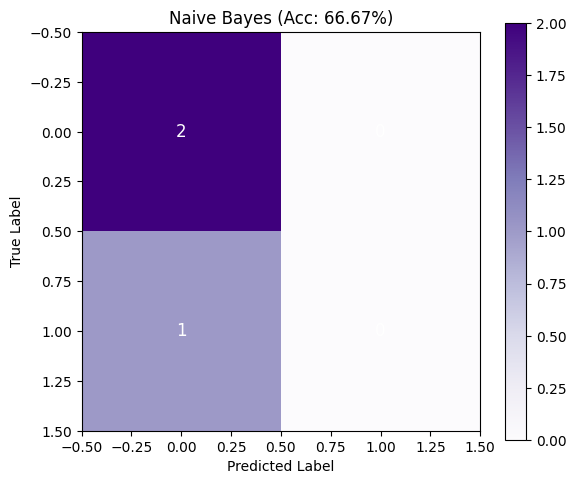

In [9]:
# 5. Naive Bayes
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0)
            self.priors[c] = X_c.shape[0] / X.shape[0]
        return self
    
    def gaussian_pdf(self, x, mean, var):
        return np.exp(-((x - mean)**2) / (2 * var)) / np.sqrt(2 * np.pi * var + 1e-10)
    
    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                posteriors[c] = np.log(self.priors[c]) + np.sum(np.log(self.gaussian_pdf(x, self.mean[c], self.var[c]) + 1e-10))
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)

nb_model = NaiveBayes().fit(X_train, y_clf_train)
y_pred_nb = nb_model.predict(X_test)
acc_nb = np.mean(y_pred_nb == y_clf_test)
print(f"Naive Bayes Accuracy: {acc_nb:.4f}")

tp = np.sum((y_pred_nb == 1) & (y_clf_test == 1))
tn = np.sum((y_pred_nb == 0) & (y_clf_test == 0))
fp = np.sum((y_pred_nb == 1) & (y_clf_test == 0))
fn = np.sum((y_pred_nb == 0) & (y_clf_test == 1))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Purples', interpolation='nearest')
plt.title(f'Naive Bayes (Acc: {acc_nb:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

K-Means Clustering: [1 0 0]


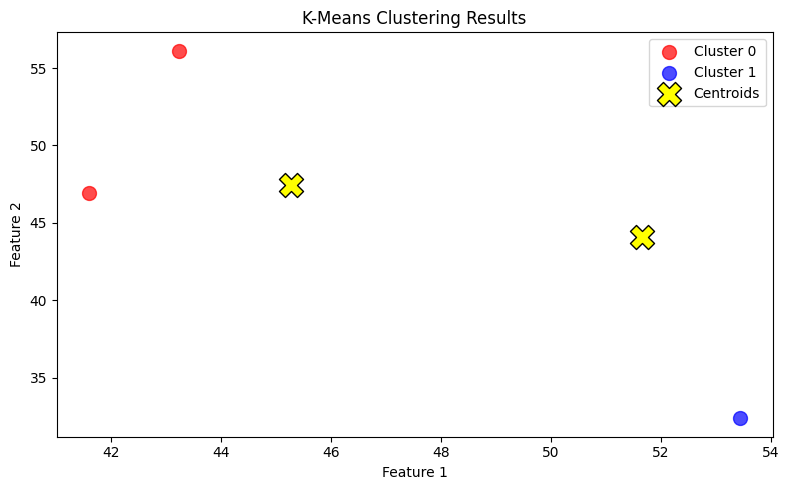

In [10]:
# 6. K-Means Clustering
class KMeans:
    def __init__(self, k=2, epochs=100):
        self.k, self.epochs = k, epochs
        self.centroids = None
    
    def fit(self, X):
        idx = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[idx]
        for _ in range(self.epochs):
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
        return self
    
    def predict(self, X):
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

km_model = KMeans(k=2, epochs=100).fit(X_train)
y_pred_km = km_model.predict(X_test)
print(f"K-Means Clustering: {y_pred_km}")

plt.figure(figsize=(8, 5))
colors = ['red', 'blue']
for i in range(2):
    idx = np.where(y_pred_km == i)[0]
    plt.scatter(X_test[idx, 0], X_test[idx, 1], c=colors[i], label=f'Cluster {i}', alpha=0.7, s=100)
plt.scatter(km_model.centroids[:, 0], km_model.centroids[:, 1], c='yellow', marker='X', s=300, edgecolors='black', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering Results')
plt.legend()
plt.tight_layout()
plt.show()

Perceptron Accuracy: 1.0000


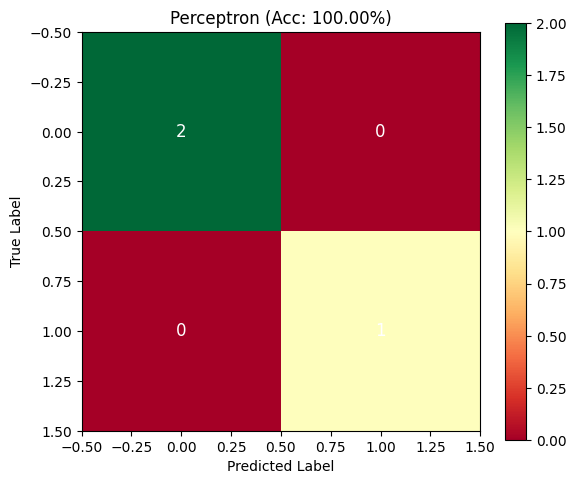

In [11]:
# 7. Perceptron
class Perceptron:
    def __init__(self, lr=0.01, epochs=100):
        self.lr, self.epochs = lr, epochs
        self.w = None
        self.b = 0
    
    def fit(self, X, y):
        if self.w is None:
            self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for x, target in zip(X, y):
                pred = 1 if (x @ self.w + self.b) > 0 else 0
                if pred != target:
                    update = self.lr * (target - pred)
                    self.w += update * x
                    self.b += update
        return self
    
    def predict(self, X):
        return (X @ self.w + self.b > 0).astype(int)

perc_model = Perceptron(lr=0.01, epochs=100).fit(X_train, y_clf_train)
y_pred_perc = perc_model.predict(X_test)
acc_perc = np.mean(y_pred_perc == y_clf_test)
print(f"Perceptron Accuracy: {acc_perc:.4f}")

tp = np.sum((y_pred_perc == 1) & (y_clf_test == 1))
tn = np.sum((y_pred_perc == 0) & (y_clf_test == 0))
fp = np.sum((y_pred_perc == 1) & (y_clf_test == 0))
fn = np.sum((y_pred_perc == 0) & (y_clf_test == 1))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='RdYlGn', interpolation='nearest')
plt.title(f'Perceptron (Acc: {acc_perc:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

PCA transformed shape: (3, 2)


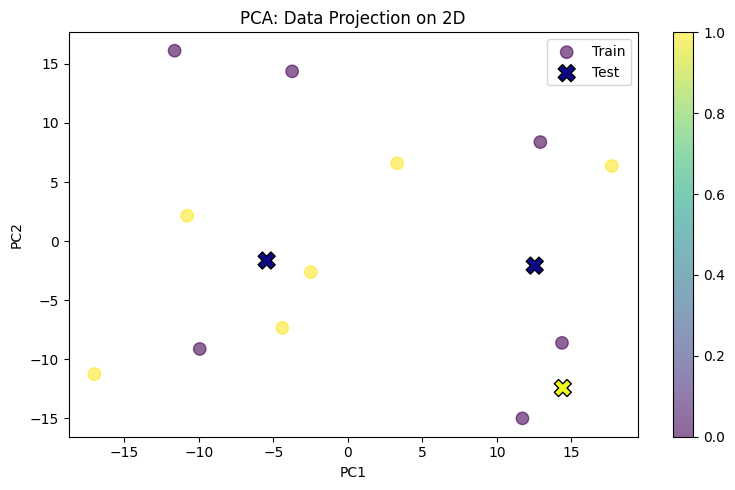

In [12]:
# 8. Principal Component Analysis (PCA)
class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.mean = None
    
    def fit(self, X):
        self.mean = X.mean(axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        idx = eigenvalues.argsort()[::-1]
        self.components = eigenvectors[:, idx[:self.n_components]].real
        return self
    
    def transform(self, X):
        return (X - self.mean) @ self.components

pca_model = PCA(n_components=2).fit(X_train)
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)
print(f"PCA transformed shape: {X_test_pca.shape}")

plt.figure(figsize=(8, 5))
scatter1 = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_clf_train, cmap='viridis', alpha=0.6, s=80, label='Train')
scatter2 = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_clf_test, cmap='plasma', marker='X', s=150, edgecolors='black', label='Test')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Data Projection on 2D')
plt.legend()
plt.colorbar(scatter1)
plt.tight_layout()
plt.show()

SVM Accuracy: 1.0000


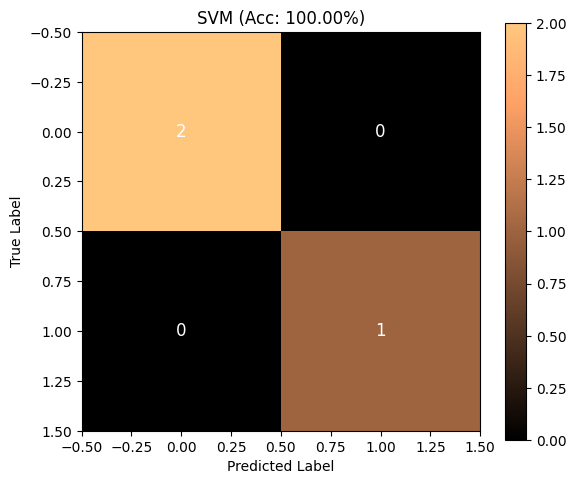

In [13]:
# 9. Support Vector Machine (SVM - Linear)
class SVM:
    def __init__(self, lr=0.001, lambda_=0.01, epochs=100):
        self.lr, self.lambda_, self.epochs = lr, lambda_, epochs
        self.w = None
        self.b = 0
    
    def fit(self, X, y):
        if self.w is None:
            self.w = np.zeros(X.shape[1])
        y = np.where(y == 0, -1, 1)
        m = X.shape[0]
        for _ in range(self.epochs):
            for i in range(m):
                if y[i] * (X[i] @ self.w + self.b) < 1:
                    self.w = self.w - self.lr * (self.w - self.lambda_ * y[i] * X[i])
                    self.b = self.b - self.lr * (-self.lambda_ * y[i])
                else:
                    self.w = self.w - self.lr * self.w
        return self
    
    def predict(self, X):
        return (X @ self.w + self.b > 0).astype(int)

svm_model = SVM(lr=0.001, lambda_=0.01, epochs=100).fit(X_train, y_clf_train)
y_pred_svm = svm_model.predict(X_test)
acc_svm = np.mean(y_pred_svm == y_clf_test)
print(f"SVM Accuracy: {acc_svm:.4f}")

tp = np.sum((y_pred_svm == 1) & (y_clf_test == 1))
tn = np.sum((y_pred_svm == 0) & (y_clf_test == 0))
fp = np.sum((y_pred_svm == 1) & (y_clf_test == 0))
fn = np.sum((y_pred_svm == 0) & (y_clf_test == 1))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='copper', interpolation='nearest')
plt.title(f'SVM (Acc: {acc_svm:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

Random Forest Accuracy: 0.6667


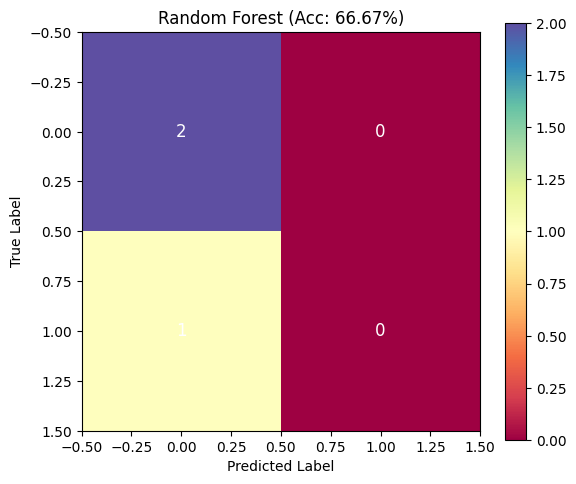

In [17]:
# 10. Random Forest (Simplified)
class RandomForest:
    def __init__(self, n_trees=5, max_depth=3):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []
    
    def fit(self, X, y):
        for _ in range(self.n_trees):
            idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
            tree = DecisionTree(max_depth=self.max_depth).fit(X[idx], y[idx])
            self.trees.append(tree)
        return self
    
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.array([np.bincount(predictions[:, i]).argmax() for i in range(X.shape[0])])

rf_model = RandomForest(n_trees=5, max_depth=3).fit(X_train, y_clf_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = np.mean(y_pred_rf == y_clf_test)
print(f"Random Forest Accuracy: {acc_rf:.4f}")

tp = np.sum((y_pred_rf == 1) & (y_clf_test == 1))
tn = np.sum((y_pred_rf == 0) & (y_clf_test == 0))
fp = np.sum((y_pred_rf == 1) & (y_clf_test == 0))
fn = np.sum((y_pred_rf == 0) & (y_clf_test == 1))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Spectral', interpolation='nearest')
plt.title(f'Random Forest (Acc: {acc_rf:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

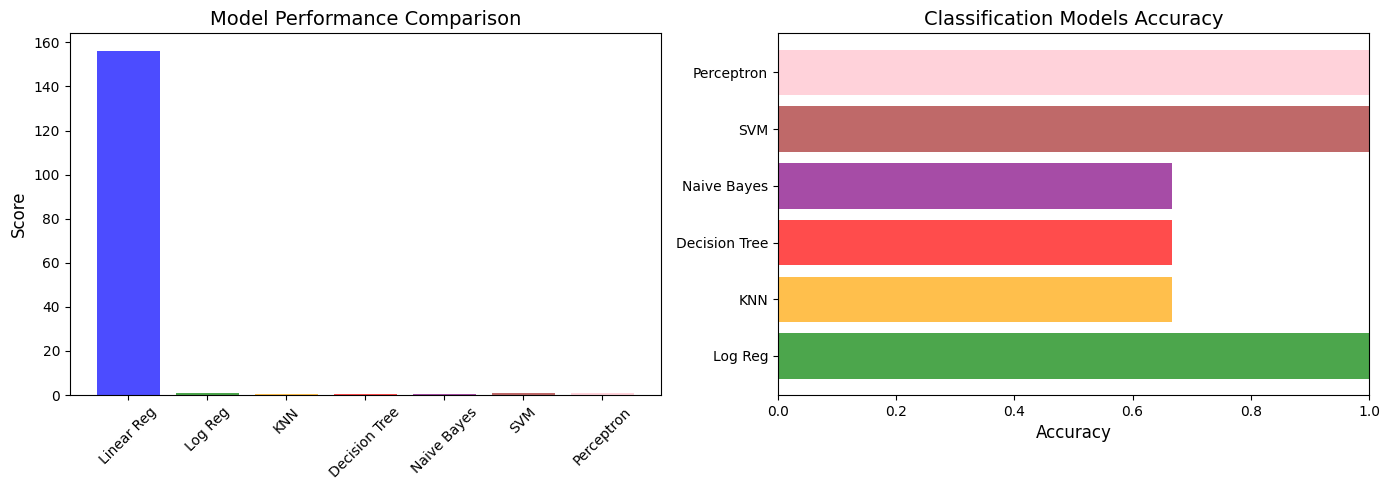

In [18]:
# Summary Visualization
models = ['Linear Reg', 'Log Reg', 'KNN', 'Decision Tree', 'Naive Bayes', 'SVM', 'Perceptron']
scores = [mse_lr, acc_log, acc_knn, acc_dt, acc_nb, acc_svm, acc_perc]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink']
ax1.bar(models, scores, color=colors, alpha=0.7)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Classification models comparison
clf_models = ['Log Reg', 'KNN', 'Decision Tree', 'Naive Bayes', 'SVM', 'Perceptron']
clf_scores = [acc_log, acc_knn, acc_dt, acc_nb, acc_svm, acc_perc]
ax2.barh(clf_models, clf_scores, color=colors[1:], alpha=0.7)
ax2.set_xlabel('Accuracy', fontsize=12)
ax2.set_title('Classification Models Accuracy', fontsize=14)
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()